# Modeling Notebook

Now that all the features are present in the data, it is time to start modeling. First, I prepare the data for modeling by removing irrelevant or redundant features. I use a sequential split to split my data into train, validation, and test splits and then scale the data. I use a Lasso regression model to choose features with non-zero coefficients and limit the amount of features I provide to my model and then I review the autocorrelation and stationarity of the data. 

After doing that, I create a class to evaluate model performance and use a dummy regressor to make a baseline for subsequent predictions. Then, I build a first simple model that feeds all of the features to a linear regression model. From there, I use feature selection to improve model performance and also try other models including Random Forest, Extra Trees, ADA Boost,  XGBoostm and LSTM. After tuning each model to try to maximize performance, I select a final model.

## 1. Imports and Preparing Data for Modeling

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np

import pandas as pd

import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Ridge
from sklearn.metrics import explained_variance_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.tree import plot_tree

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

import xgboost as xgb

In [2]:
df = pd.read_csv('./Data/all_features_clean.csv')

In [3]:
df.head()

,key_0,SEASON_ID,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,MIN,...,UPCOMING_OPPONENT_TEAM_PCT_PTS_2PT_MR_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_3PT_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_FB_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_FT_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_OFF_TOV_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_PTS_PAINT_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_UAST_2PM_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_UAST_3PM_ROLLING,UPCOMING_OPPONENT_TEAM_PCT_UAST_FGM_ROLLING,UPCOMING_OPPONENT_TEAM_ABBREVIATION
0,LAL,22015,203952,Andrew Wiggins,1610612750,Minnesota Timberwolves,21500017,2015-10-28,MIN @ LAL,29,...,0.114,0.371,0.086,0.114,0.143,0.400,0.370,0.308,0.350,DEN
1,SAS,22015,201142,Kevin Durant,1610612760,Oklahoma City Thunder,21500013,2015-10-28,OKC vs. SAS,35,...,0.207,0.172,0.138,0.092,0.172,0.529,0.500,0.200,0.459,ORL
2,PHX,22015,1626257,Salah Mejri,1610612742,Dallas Mavericks,21500014,2015-10-28,DAL @ PHX,2,...,0.324,0.162,0.072,0.189,0.198,0.324,0.583,0.167,0.524,LAC
3,NYK,22015,203948,Johnny O'Bryant III,1610612749,Milwaukee Bucks,21500012,2015-10-28,MIL vs. NYK,17,...,0.250,0.239,0.193,0.170,0.159,0.341,0.538,0.286,0.485,WAS
4,OKC,22015,2225,Tony Parker,1610612759,San Antonio Spurs,21500013,2015-10-28,SAS @ OKC,26,...,0.320,0.000,0.080,0.220,0.220,0.460,0.513,0.000,0.513,BKN


There is one pesky key_0 column. I get rid of that.

In [4]:
df.drop('key_0',axis=1,inplace=True)

In [5]:
df.isna().sum().any()

False

In [6]:
df.columns.tolist()

['SEASON_ID',
 'PLAYER_ID',
 'PLAYER_NAME',
 'TEAM_ID',
 'TEAM_NAME',
 'GAME_ID',
 'GAME_DATE',
 'MATCHUP',
 'MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'PLUS_MINUS',
 'PLAYER_GAME_ID',
 'AST_PCT',
 'AST_RATIO',
 'AST_TO',
 'DEF_RATING',
 'DREB_PCT',
 'EFG_PCT',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_TOV_PCT',
 'E_USG_PCT',
 'FGA_PG',
 'FGM_PG',
 'NET_RATING',
 'OFF_RATING',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PIE',
 'POSS',
 'REB_PCT',
 'SEASON_YEAR',
 'TM_TOV_PCT',
 'TS_PCT',
 'USG_PCT',
 'sp_work_DEF_RATING',
 'sp_work_NET_RATING',
 'sp_work_OFF_RATING',
 'sp_work_PACE',
 'BLKA',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'PFD',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_OFF_TOV',
 'PTS_PAINT',
 'PCT_AST_2PM',
 'PCT_AST_3PM',
 'PCT_AST_FGM',
 'PCT_FGA_2PT',
 'PCT_FGA_3PT',
 'PCT_PTS_2PT',
 'PCT_PTS_2PT_MR',


There are no nulls, so I identify the features that I want to use for modeling.

In [7]:
numeric_columns = df.select_dtypes(['float', 'int'])

In [8]:
cols_to_remove = ['SEASON_ID','PLAYER_ID','TEAM_ID','GAME_ID','SEASON_ID_EXPANDING','PLAYER_ID_EXPANDING',
                  'SEASON_ID_ROLLING','PLAYER_ID_ROLLING','UPCOMING_opponent_id', 'UPCOMING_home',
                  'TEAM_GAME_ID','TEAM_ID','opponent_id','opponent_game_id','opponent_id', 'OPPONENT_TEAM_ID',
                  'PLAYER_GAME_ID','target','UPCOMING_OPPONENT_TEAM_ID','UPCOMING_OPPONENT_TEAM_GAME_ID',
                 'UPCOMING_OPPONENT_TEAM_PACE', 'TEAM_PCT_UAST_2PM_ROLLING','TEAM_PACE_EXPANDING',
                 'FGA_PG','FGA_PG_EXPANDING', 'FGA_PG_ROLLING','sp_work_DEF_RATING_ROLLING', 
                  'UPCOMING_OPPONENT_TEAM_PCT_AST_FGM_ROLLING', 'FGM_PG_ROLLING', 'FGM_PG_EXPANDING',
                 'UPCOMING_OPPONENT_TEAM_MIN_ROLLING','UPCOMING_OPPONENT_TEAM_MIN_EXPANDING',
                 'PCT_FGA_2PT_EXPANDING','PCT_FGA_2PT_ROLLING','PCT_FGA_2PT']

In [9]:
selected_cols = [item for item in numeric_columns if item not in cols_to_remove]

In [10]:
df[selected_cols].columns.tolist()

['MIN',
 'FGM',
 'FGA',
 'FG_PCT',
 'FG3M',
 'FG3A',
 'FG3_PCT',
 'FTM',
 'FTA',
 'FT_PCT',
 'OREB',
 'DREB',
 'REB',
 'AST',
 'STL',
 'BLK',
 'TOV',
 'PF',
 'PTS',
 'PLUS_MINUS',
 'AST_PCT',
 'AST_RATIO',
 'AST_TO',
 'DEF_RATING',
 'DREB_PCT',
 'EFG_PCT',
 'E_DEF_RATING',
 'E_NET_RATING',
 'E_OFF_RATING',
 'E_PACE',
 'E_TOV_PCT',
 'E_USG_PCT',
 'FGM_PG',
 'NET_RATING',
 'OFF_RATING',
 'OREB_PCT',
 'PACE',
 'PACE_PER40',
 'PIE',
 'POSS',
 'REB_PCT',
 'TM_TOV_PCT',
 'TS_PCT',
 'USG_PCT',
 'sp_work_DEF_RATING',
 'sp_work_NET_RATING',
 'sp_work_OFF_RATING',
 'sp_work_PACE',
 'BLKA',
 'OPP_PTS_2ND_CHANCE',
 'OPP_PTS_FB',
 'OPP_PTS_OFF_TOV',
 'OPP_PTS_PAINT',
 'PFD',
 'PTS_2ND_CHANCE',
 'PTS_FB',
 'PTS_OFF_TOV',
 'PTS_PAINT',
 'PCT_AST_2PM',
 'PCT_AST_3PM',
 'PCT_AST_FGM',
 'PCT_FGA_3PT',
 'PCT_PTS_2PT',
 'PCT_PTS_2PT_MR',
 'PCT_PTS_3PT',
 'PCT_PTS_FB',
 'PCT_PTS_FT',
 'PCT_PTS_OFF_TOV',
 'PCT_PTS_PAINT',
 'PCT_UAST_2PM',
 'PCT_UAST_3PM',
 'PCT_UAST_FGM',
 'PCT_AST',
 'PCT_BLK',
 'PCT_BLKA'

I have the feature columns ready, so I move on to split the data into train, validate, and test.

## 2. Sequential Split for Train, Val, Test and Scaling Independent Variables

In this section, I use a sequential split to create train, validate, and test sets. I use the first six seasons for my train, the 7th season for my validate, and the 8th season as my test.

In [11]:
X = df[selected_cols]
y = df['target']

In [12]:
seasons = df['SEASON_ID'].unique()
seasons

array([22015, 22016, 22017, 22018, 22019, 22020, 22021, 22022],
      dtype=int64)

In [13]:
train_seasons = seasons[:6]
train_data = df[df['SEASON_ID'].isin(train_seasons)]
X_train = train_data[selected_cols]
y_train = train_data['target']

In [14]:
val_season = seasons[6]
val_data = df[df['SEASON_ID'] == val_season]
X_val = val_data[selected_cols]
y_val = val_data['target']

In [15]:
test_season = seasons[7]
test_data = df[df['SEASON_ID'] == test_season]
X_test = test_data[selected_cols]
y_test = test_data['target']

Now that I have used a sequential split to separate into train, val, and test, I scale each set.

In [16]:
ss = StandardScaler()

In [17]:
X_train_scaled = ss.fit_transform(X_train)
X_val_scaled = ss.fit_transform(X_val)
X_test_scaled = ss.fit_transform(X_test)

## 3. Feature Selection with Lasso

My modeling data has over 700 features, so one of my first steps is to use a Lasso regression model to drop the least impactful features from the data set. I begin with a lasso cv model to figure out the best alpha to use. Then, I use a lasso model and drop the features that have a 0 coefficient after Lasso.

I comment out Lasso cv model because it takes a long time to run. The results of the cv show that the best alpha to use is .01.

In [18]:
#lasso_cv_model = LassoCV(alphas=[0.001, 0.01, 0.1, 1.0, 10.0], cv=5, max_iter=10000)

In [19]:
#lasso_cv_model.fit(X_train_scaled, y_train)

In [20]:
#best_alpha = lasso_cv_model.alpha_
#best_alpha

Now that I know the best alpha, I use it in a lasso model to see which feature coefficients drop to 0.

In [21]:
lasso_model = Lasso(alpha=0.01)

In [22]:
lasso_model.fit(X_train_scaled, y_train)

Lasso(alpha=0.01)

In [23]:
coefficients = lasso_model.coef_

In [24]:
feature_names = X.columns

In [25]:
lasso_coefficients_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
lasso_coefficients_df['Coefficient'].value_counts()

Coefficient
 0.000000    496
-0.006327      1
-0.016963      1
 0.068400      1
-0.010671      1
            ... 
 0.114775      1
-0.000730      1
-0.059590      1
 0.052262      1
 0.009407      1
Name: count, Length: 201, dtype: int64

500 features had a coefficient of 0 in the Lasso model. Removing those allows me to greatly reduce the dimensionality of the data.

In [26]:
selected_features = lasso_coefficients_df[lasso_coefficients_df['Coefficient'] != 0]
selected_features.shape

(200, 2)

I review the 10 features with the strongest positive weight and the 10 features with the strongest negative weight.

In [27]:
selected_features.sort_values(by = 'Coefficient',ascending=False).head(10)

,Feature,Coefficient
329,FGA_ROLLING,1.142199
185,PTS_EXPANDING,1.076700
169,FGA_EXPANDING,0.770895
2,FGA,0.540256
0,MIN,0.419399
174,FTM_EXPANDING,0.342442
345,PTS_ROLLING,0.316836
334,FTM_ROLLING,0.300785
172,FG3A_EXPANDING,0.235420
382,PTS_PAINT_ROLLING,0.206879


There is an interesting mix here. The expanding average for points has a much higher coefficient than the rolling average. All of the measures of field goal attempts have strong coefficients, but field goals made does not appear in the top 10 while free thorws made does. Minutes are also an important feature. There is a whole lot of redundancy and multicollinearity here, which is to be expected based on how I collected the data and added features. I will have to address that during modeling.

In [28]:
selected_features.sort_values(by = 'Coefficient',ascending=False).tail(10)

,Feature,Coefficient
184,PF_EXPANDING,-0.069309
237,PCT_UAST_FGM_EXPANDING,-0.070130
90,TEAM_MIN,-0.070457
238,PCT_AST_EXPANDING,-0.079252
233,PCT_PTS_OFF_TOV_EXPANDING,-0.080412
594,UPCOMING_OPPONENT_TEAM_PIE_EXPANDING,-0.084081
164,BIO_DRAFT_NUMBER,-0.088112
325,days_of_rest_EXPANDING,-0.100827
10,OREB,-0.104138
486,UPCOMING_days_of_rest,-0.206651


Days of rest looks like an important feature here, as it appears in two different versions. The average player impact estimate (PIE) for the upcoming opponent also plays a role as does the player's draft number. In general, there is more variety here than there was in the features with positive coefficients.

Now that I have a basic understanding of the data after Lasso, I scale it and create versions of my train, validation, and test splits that only use the features with non-zero coefficients.

In [29]:
X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X.columns)
X_val_scaled_df = pd.DataFrame(X_val_scaled,columns=X.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled,columns=X.columns)

In [30]:
selected_feature_names = selected_features['Feature'].tolist()

In [31]:
X_train_lasso = X_train_scaled_df[selected_feature_names]
X_val_lasso = X_val_scaled_df[selected_feature_names]
X_test_lasso = X_test_scaled_df[selected_feature_names]

With the data scaled and the first round of feature selection finished, I review the autocorrelation and stationarity of the data before going to modeling.

## 4. Stationarity and Autocorrelation Analysis

To check the stationarity and autocorrelation of the data, I use the records for Mikal Bridges to get a sense of how things look for one player.

In [32]:
bridges_df = df.loc[df['PLAYER_NAME'] == 'Mikal Bridges']

In [33]:
bridges_df.set_index(bridges_df['GAME_DATE'],drop=True,inplace=True)

First, I review the stationarity of the data by looking at Bridges points over time and expanding points average over time.

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a 

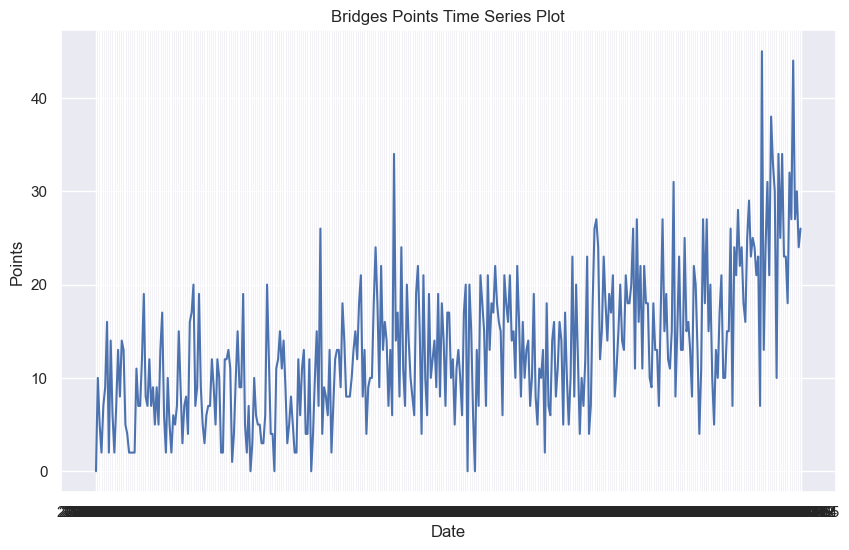

In [34]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(bridges_df['PTS'])
plt.xlabel('Date')
plt.ylabel('Points')
plt.title('Bridges Points Time Series Plot')
plt.show()

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a 

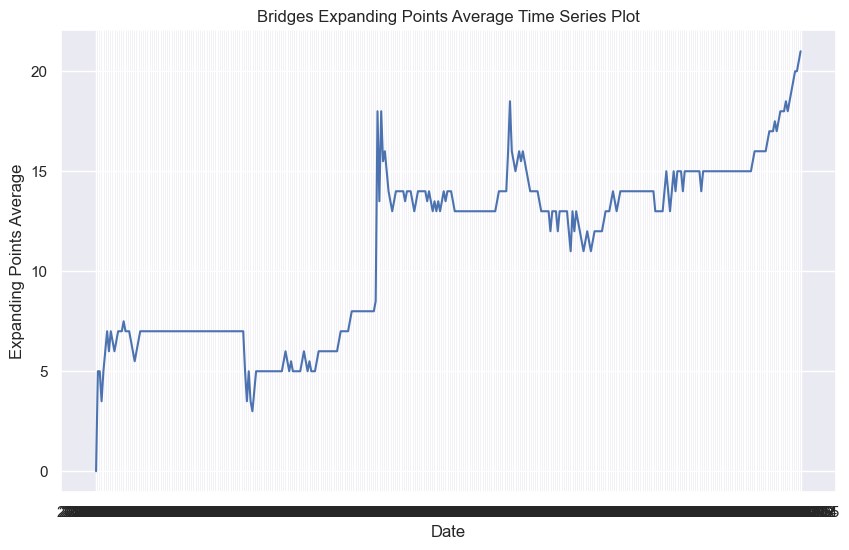

In [35]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(bridges_df['PTS_EXPANDING'])
plt.xlabel('Date')
plt.ylabel('Expanding Points Average')
plt.title('Bridges Expanding Points Average Time Series Plot')
plt.show()

The first plot shows how much variation there is even in the game to game scoring for a single player. Overall, the values trend upwards over time, which makes sense given his increase in playing time and development over the years. The time series plot of his expanding points average further emphasizes the increase in his points over time and substantially smooths the game to game fluctuations. This shows that, for individual players, there is not stationarity in the data; it changes over time. Within a given season, though, there is a fair amount of stability.

Next, I plot the autocorrelation function and partial autocorrelation function for Mikal Bridges points.

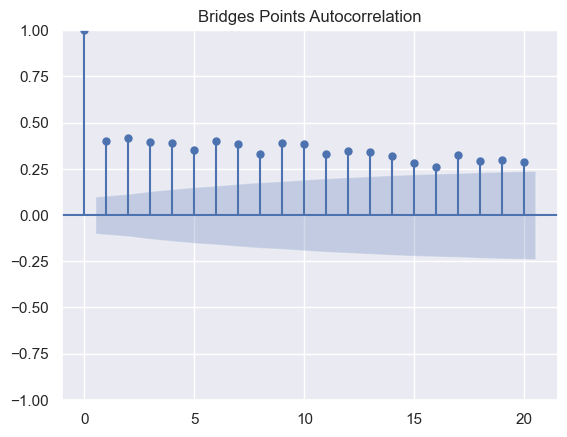

In [36]:
plot_acf(bridges_df['PTS'], lags=20)
plt.title('Bridges Points Autocorrelation')
plt.show()

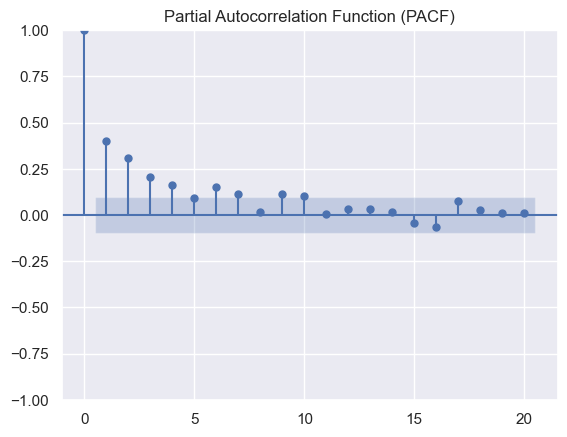

In [37]:
plot_pacf(bridges_df['PTS'], lags=20)
plt.title('Partial Autocorrelation Function (PACF)')
plt.show()

In the plot of the autocorrelation function, all of the lags show substantial, non-zero correlation that falls outside the confidence interval. In the partial autocorrelation function, most of the lags from lags 1-10 show substantial correlation, and the lags after 10 do not. This suggests that the time series is not random. Because the partial autocorrelation function skips intermediate lags and compares each lag to the original, it also shows that the intermediate lags contribute to the correlation with the subsequent lags. Since my model is for many players, though, I make a new visualization to explore the stationarity of points for all players from the 2015-16 season.

In [38]:
one_season_df = df.loc[df['SEASON_ID'] == 22015]
one_season_df.set_index(one_season_df['GAME_DATE'],drop=True,inplace=True)

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a 

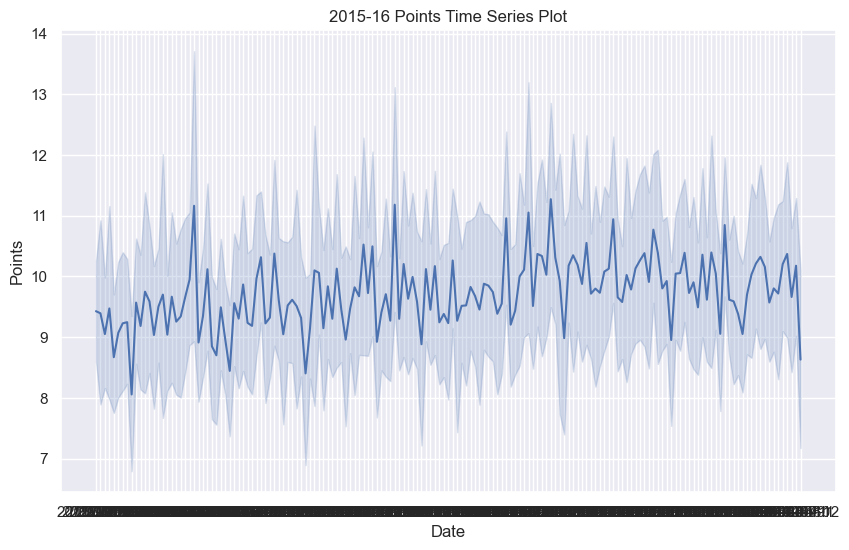

In [39]:
sns.set(style="darkgrid")
plt.figure(figsize=(10, 6))
sns.lineplot(one_season_df['PTS'])
plt.xlabel('Date')
plt.ylabel('Points')
plt.title('2015-16 Points Time Series Plot')
plt.show()

Over the course of the 2015-16 season, the points for all players may show a slight increase as the season progresses, but overall, the data is fairly stationary. Overall, there is autocorrelation for points scored for a specific player, and the data is not stationary on a one-player level. However, the data is stationary when looking at all of the players. Given these trends, I use decide to use standard machine learning models like linear regression and random forest as well as an lstm neural network to see which model handles the data best.

## 4. Building a Class for Model Evaluation and Creating a Dummy Regressor for Baseline Results

With the data split and scaled, and with some basic feature selection complete, I move into the modeling process. First, I build a class that will evaluate a model based on five metrics-- mean squared error, mean absolute error, r squared, max error, and explained variance-- and append the results to a DataFrame that updates each time I run a new model. This allows me to iterate through models and compare each model's performance to the performance of previous models in an efficient manner.

In [40]:
# I adapted this code from code written by David Hartsman for our Flatiron School phase 4 project

class Model():
    model_list = []
    model_df = pd.DataFrame(columns=['Name', 'MSE', 'MAE', 'R2', 'Max Error', 'Explained Variance'])
    
    
    def __init__(self, name, model, X_val, y_val):
        self.name = name
        self.model = model
        self.X_val = X_val
        self.y_val = y_val
        
       # Test metrics
        self.y_pred = self.model.predict(self.X_val)
        
        mse = mean_squared_error(self.y_val, self.y_pred)
        mae = mean_absolute_error(self.y_val, self.y_pred)
        r2 = r2_score(self.y_val, self.y_pred)
        max_err = max_error(self.y_val, self.y_pred)
        evs = explained_variance_score(self.y_val, self.y_pred)
        
        Model.model_list.append(self)
        
        self.attributes = {
            'Name': name,
            'MSE': mse,
            'MAE': mae,
            'R2': r2,
            'Max Error': max_err,
            'Explained Variance': evs
        }
        
        Model.model_df.loc[len(Model.model_df)] = self.attributes
        
    def __repr__(self):
        return f"Model name: {self.name}"
    
    
    @classmethod
    def get_model_list(cls):
        return cls.model_list

Now that I have built the class, I instantiate it and use it with a dummy regressor to get a baseline prediction that I can use as a baseline for my future models. I set the strategy to median so that it is less influenced by outliers; essentially, it will predict that every player scores the median value in the points expanding average column.

In [41]:
baseline_dummy_model = DummyRegressor(strategy = 'median')

In [42]:
baseline_dummy_model.fit(X_train_lasso['PTS_EXPANDING'], y_train)

DummyRegressor(strategy='median')

In [43]:
Model('baseline_dummy',baseline_dummy_model, X_val_lasso, y_val)

Model name: baseline_dummy

In [44]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.0,0.0


The average error is 6.68 points per prediction, and the r squared score is negative, indicating a very bad goodness of fit. None of the variance is explained by the model. Results like this are to be expected given the simplistic nature of the model; now it is time to try to improve these results with a model that fits the data better.

## 5. Modeling

### 5a. First Simple Model: MLR

Now that I have a baseline from my dummy regressor, I use multiple linear regression for a first simple model. There is a good amount of multicollinearity in the features, which I will have to address to try to improve model performance. For the first iteration, though I use MLR on all of the features that were not dropped to zero during the lasso regression to get a starting point.

In [45]:
mlr = LinearRegression()
mlr.fit(X_train_lasso,y_train)

LinearRegression()

In [46]:
tscv = TimeSeriesSplit(n_splits=3)

In [47]:
cross_val_score(mlr, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.33647155, -4.52905961, -4.55701678])

The cross validation score for the first fold is substantially better than the score for the next two. Predictions made for later in a given season, when rolling and expanding averages have had time to stabilize, may be more accurate than predictions made earlier in the season when those averages may still be in flux. That fold may have more of those samples from later in the season.

In [48]:
Model('mlr_fsm',mlr, X_val_lasso, y_val)

Model name: mlr_fsm

In [49]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695


Simply using a linear regression model provided a big improvement when compared to the dummy. The average error dropped to 4.57 points, and the goodness of fit and explained variance jumped substantially. However, the model performed worse on the validation data than it did on the train data during cross validation, suggesting that it may be overfit. To try to improve the model's performance, I review the coefficients.

In [50]:
mlr_fsm_coefficients = mlr.coef_

In [51]:
feature_coefficients = pd.DataFrame({'Feature': X_val_lasso.columns, 'Coefficient': mlr_fsm_coefficients})
feature_coefficients = feature_coefficients.sort_values(by='Coefficient',ascending=False)
feature_coefficients.head(10)

,Feature,Coefficient
104,FGA_ROLLING,1.095065
59,PTS_EXPANDING,1.037137
51,FGA_EXPANDING,0.911643
1,FGA,0.534612
0,MIN,0.432086
55,FTM_EXPANDING,0.400413
53,FG3A_EXPANDING,0.291872
107,FTM_ROLLING,0.284894
124,PTS_PAINT_ROLLING,0.232069
112,PTS_ROLLING,0.228430


The top features likely have significant multicollinearity, as they are different versions of the same statistic. I will need to address that to try to improve model performance.

In [52]:
feature_coefficients.tail(10)

,Feature,Coefficient
80,PCT_PTS_OFF_TOV_EXPANDING,-0.098201
87,PCT_FTA_EXPANDING,-0.103948
178,UPCOMING_OPPONENT_TEAM_PIE_EXPANDING,-0.105382
70,OPP_PTS_PAINT_EXPANDING,-0.110018
101,days_of_rest_EXPANDING,-0.110882
3,OREB,-0.114556
47,BIO_DRAFT_NUMBER,-0.163096
84,PCT_AST_EXPANDING,-0.168598
66,POSS_EXPANDING,-0.191659
149,UPCOMING_days_of_rest,-0.220942


There isn't as much obvious multicollinearity here, but there may still be some. I use a correlation matrix to take a closer look.

In [53]:
mlr_fsm_mid_features_df = feature_coefficients[(feature_coefficients['Coefficient'].abs() > .1)]
mlr_fsm_mid_features_df = mlr_fsm_mid_features_df.sort_values(by='Coefficient')

In [54]:
mlr_fsm_mid_features = mlr_fsm_mid_features_df['Feature'].tolist()

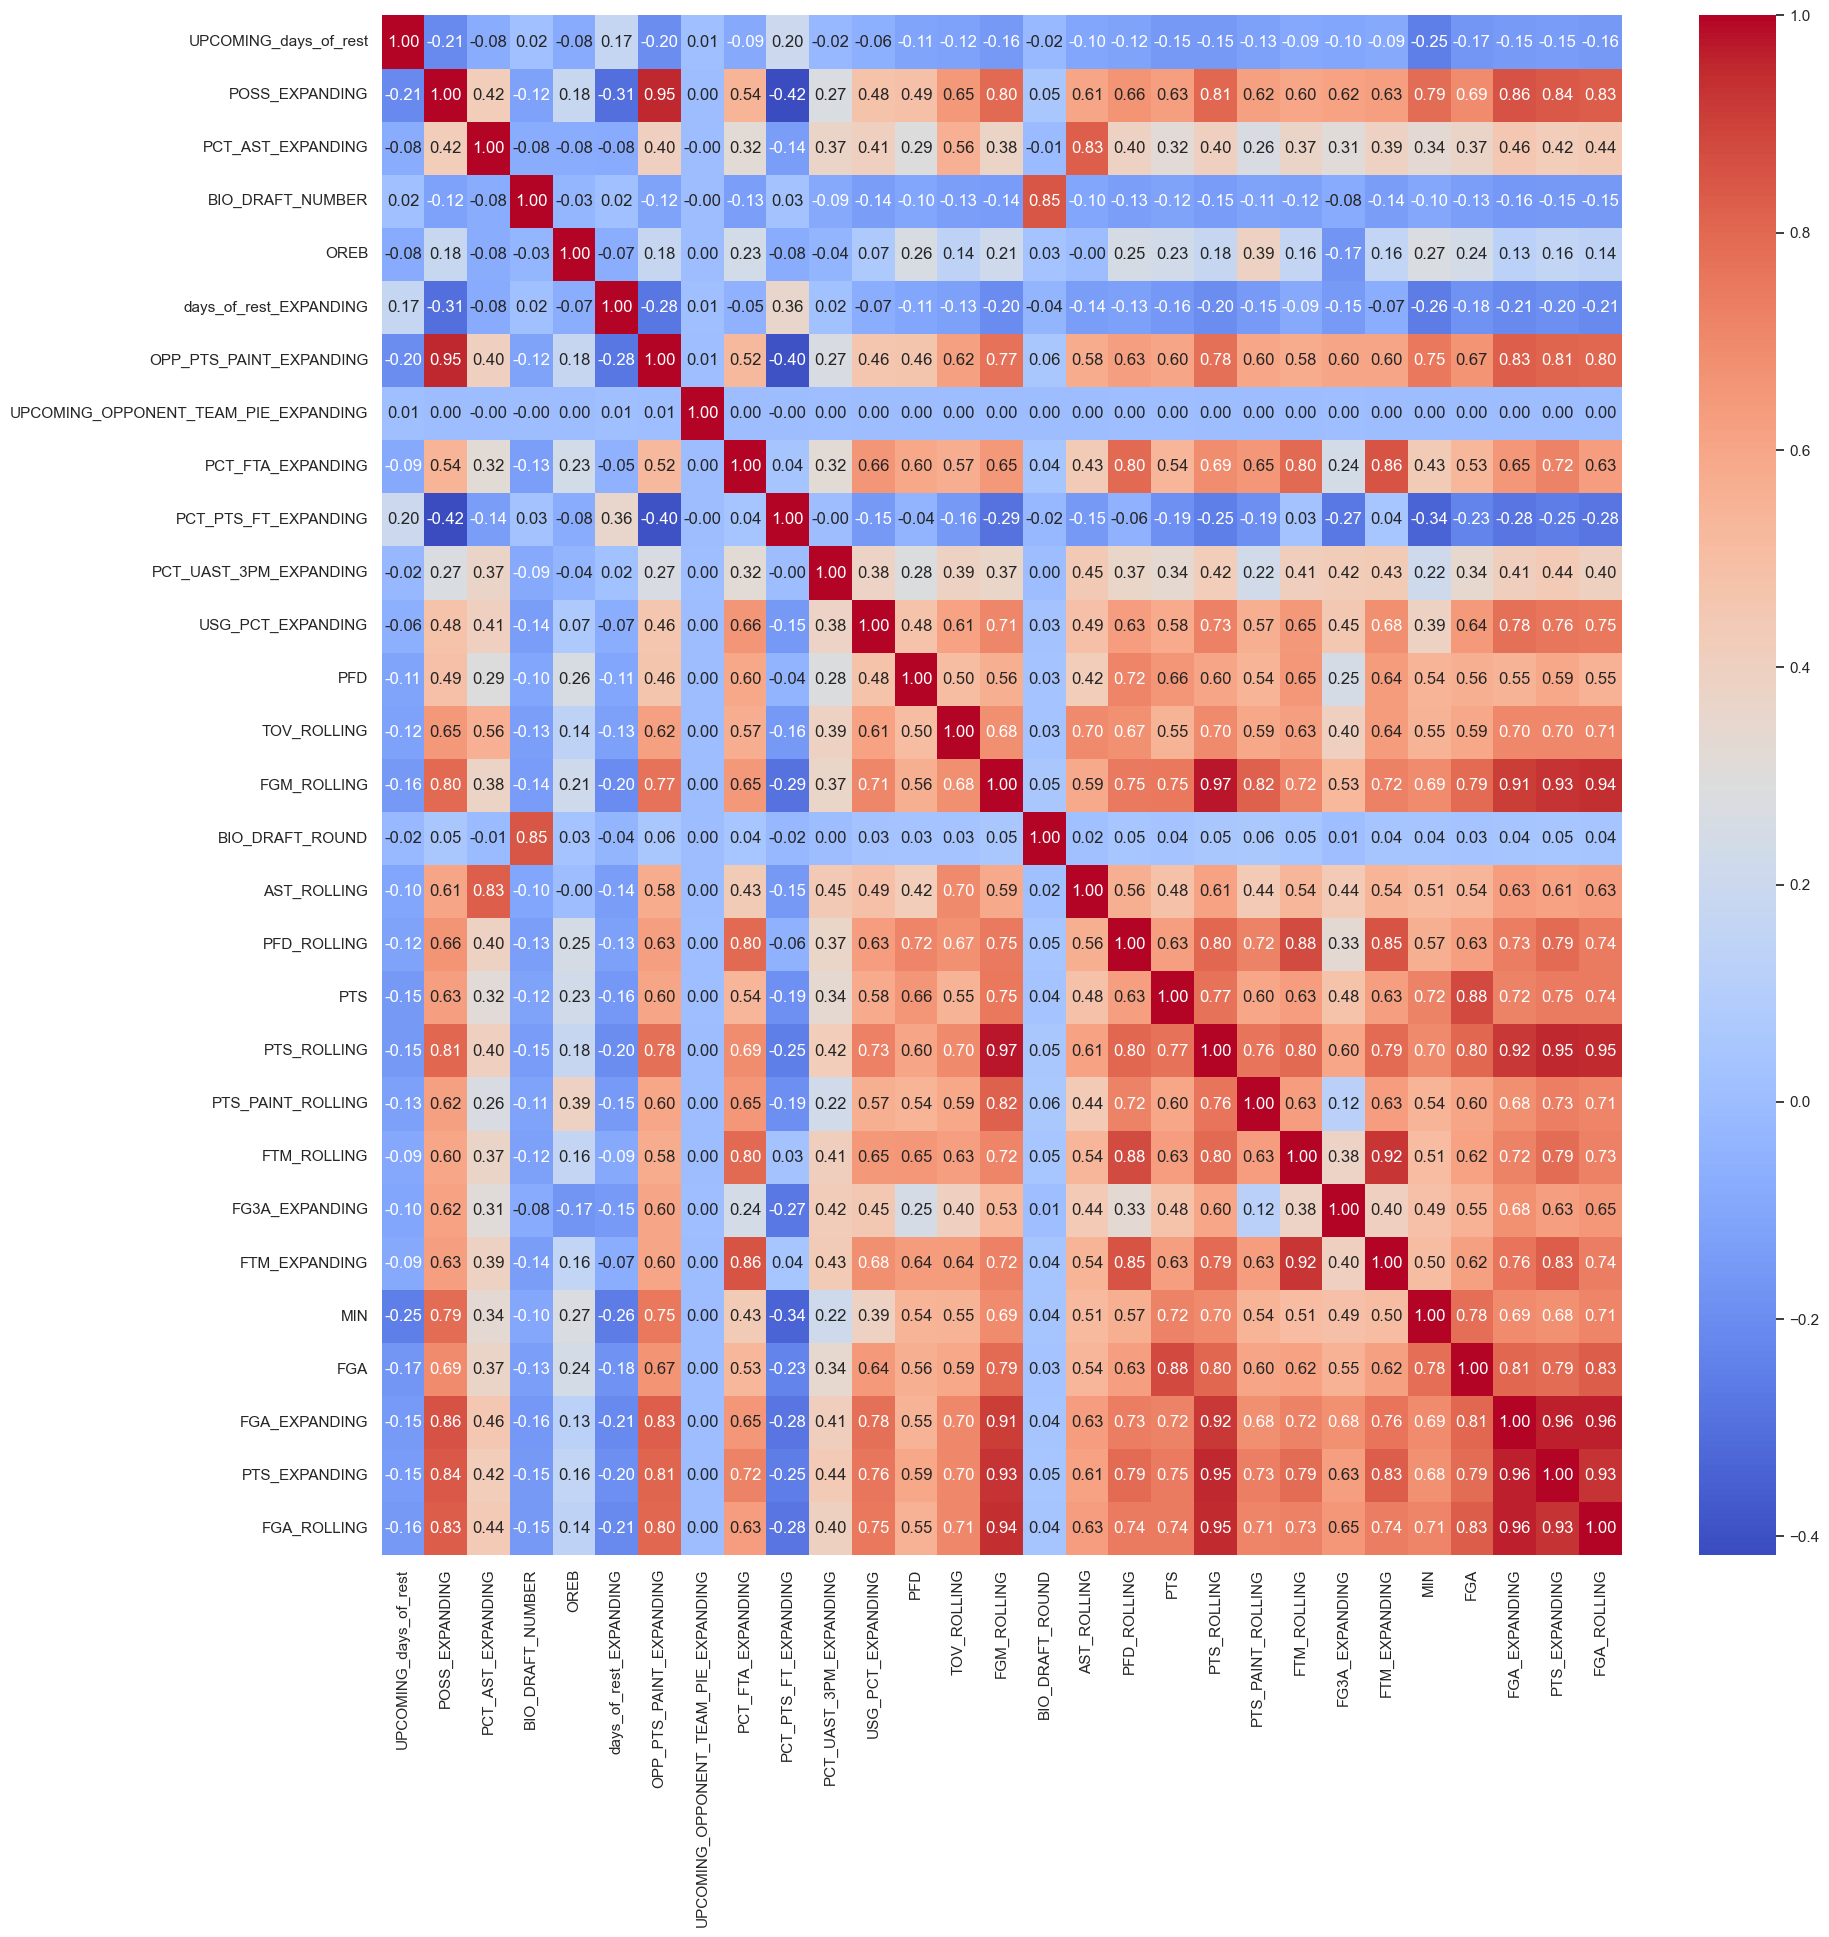

In [55]:
corr_matrix = X_train_lasso[mlr_fsm_mid_features].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

As expected, there is substantial multicollinearity in the data. I try two methods to address it. First, I use PCA to reduce the dimensionality of the data. Then I use manual feature selection.

#### 5a.1. MLR with PCA to Reduce Multicollinearity

I use PCA to reduce the dimensionality of the data in the hopes of limiting multicollinearity. While it is not shown in the notebook, I tried several values for the number of components, and 5 provided the strongest results on the train data.

In [57]:
pca = PCA(n_components=5,random_state=42)

In [58]:
X_train_pca = pca.fit_transform(X_train_lasso)
X_val_pca = pca.fit_transform(X_val_lasso)
X_test_pca = pca.fit_transform(X_test_lasso)

In [59]:
X_train_pca.shape

(146449, 5)

In [60]:
mlr_pca = LinearRegression()

In [61]:
mlr_pca.fit(X_train_pca,y_train)

LinearRegression()

In [62]:
cross_val_score(mlr_pca, X_train_pca, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.44175914, -4.677282  , -4.67387285])

In [63]:
Model('mlr_pca',mlr_pca, X_val_pca, y_val)

Model name: mlr_pca

In [64]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814


In terms of all the major metrics, the PCA transformation performed worse than the first simple model. It also seems to be overfit because it performed worse on the validation data than it did on any fold during cross validation. Next, I try to reduce multicollinearity by removing features myself.

#### 5a.2. MLR with Manual Feature Selection to Reduce Multicollinearity

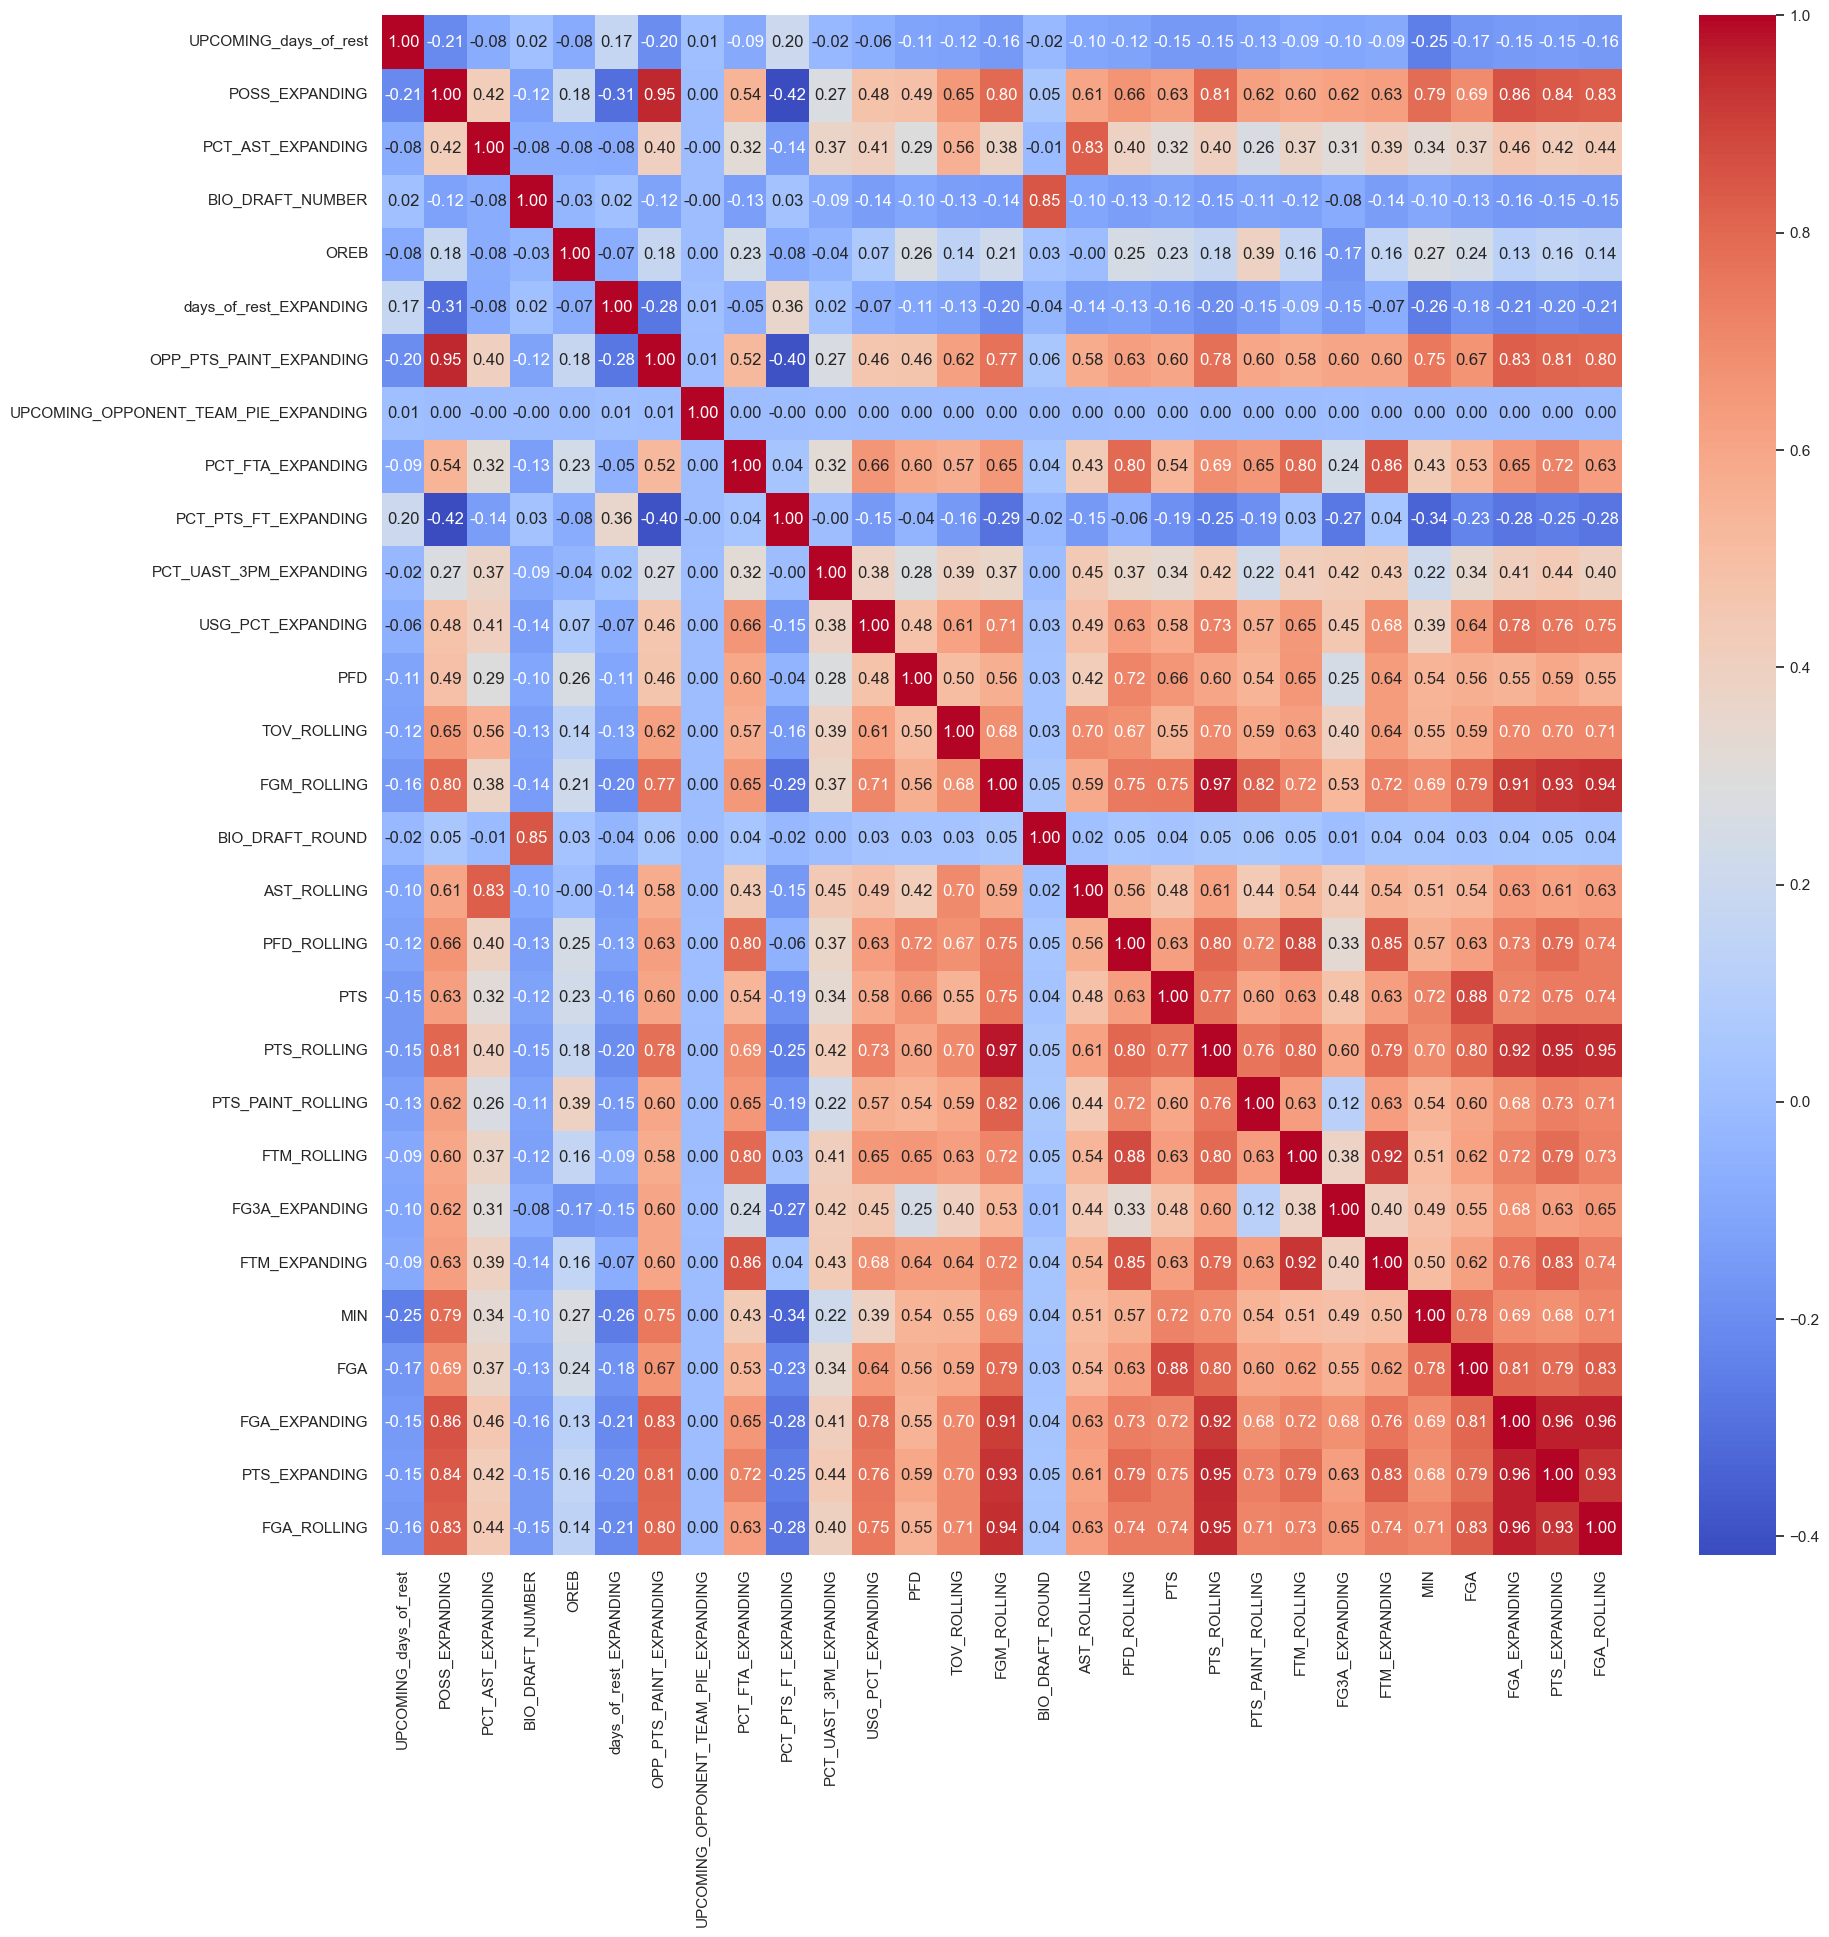

In [65]:
corr_matrix = X_train_lasso[mlr_fsm_mid_features].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

In [66]:
cols_to_remove = ['PCT_AST_EXPANDING','BIO_DRAFT_ROUND','OPP_PTS_PAINT_EXPANDING','FGA_EXPANDING','PFD_ROLLING',
                 'FGA','FGA_EXPANDING','FG3A_EXPANDING','FTM_ROLLING','PTS_ROLLING','FGM_ROLLING','FTM_EXPANDING',
                 'FGA_ROLLING','POSS_EXPANDING','PTS','PTS_EXPANDING','TOV_ROLLING']

In [67]:
revised_mlr_cols = [col for col in mlr_fsm_mid_features if col not in cols_to_remove]

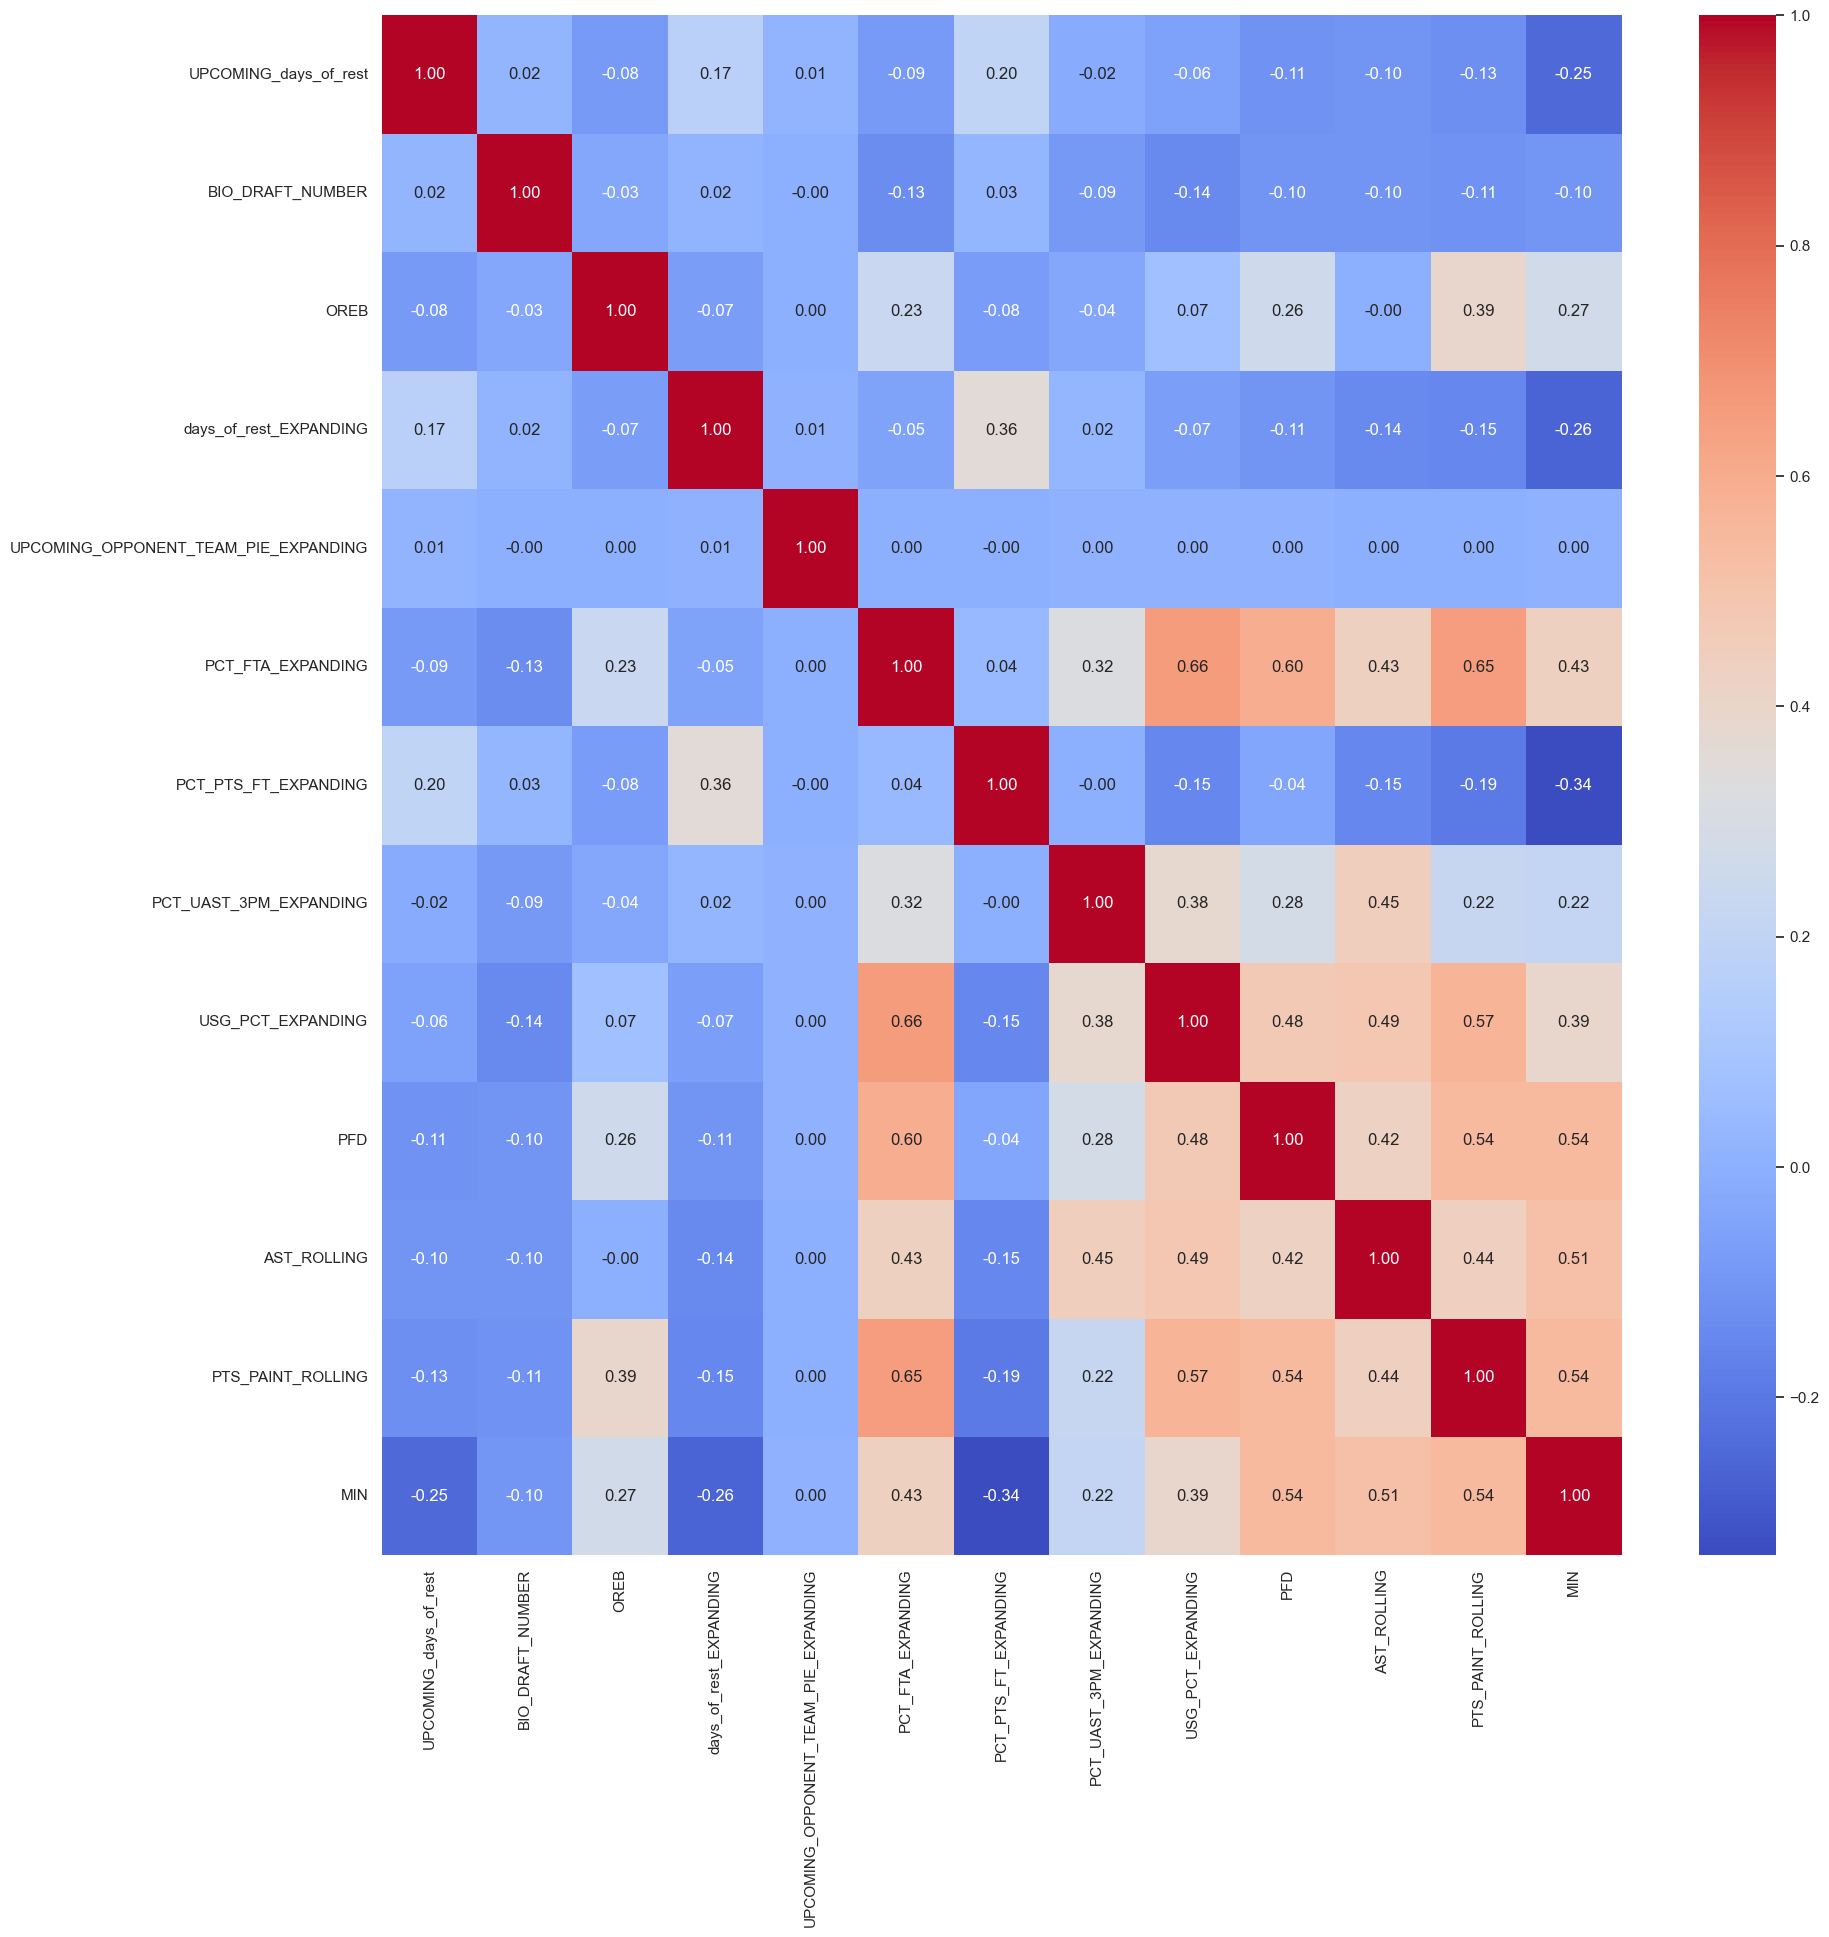

In [68]:
corr_matrix = X_train_lasso[revised_mlr_cols].corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

Now, all of the remaining features have a Pearson's correlation coefficient of .7 or less. I try the model again with this reduced multicollinearity.

In [69]:
mlr_reduced_mc = LinearRegression()

In [70]:
mlr_reduced_mc.fit(X_train_lasso[revised_mlr_cols],y_train)

LinearRegression()

In [71]:
cross_val_score(mlr_reduced_mc, X_train_lasso[revised_mlr_cols], y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.53586645, -4.72639033, -4.75269562])

In [72]:
Model('mlr_reduced_mc',mlr_reduced_mc, X_val_lasso[revised_mlr_cols], y_val)

Model name: mlr_reduced_mc

In [73]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288


Doing multiple linear regression with the features to reduce multicollinearity performs worse than the first simple model as well as the MLR with PCA in all of the major metrics. Since the first linear regression model performed the best, I see how it performs on my test data.

#### 5a.3 FIrst Model with Test Data

In [74]:
Model('mlr_test', mlr, X_test_lasso, y_test)

Model name: mlr_test

In [75]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591


Interestingly, the mlr model performed worse on the test data in terms of the mean absolute error, but substantially better in terms of r squared and explained variance. Now that I have tried a few mlr models, I try a ridge regression model to see if it reduces overfitting using regularization.

### 5b. Ridge Model

Based on the overfitting seen based on the difference between the cross validation scores and the model performance on the validation data, I use a ridge model to see if regularization helps the model generalize.

In [77]:
ridge_model = Ridge(alpha=1)

In [78]:
ridge_model.fit(X_train_lasso,y_train)

Ridge(alpha=1)

In [79]:
cross_val_score(ridge_model, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.33646613, -4.5290577 , -4.55701591])

In [80]:
Model('ridge',ridge_model, X_val_lasso, y_val)

Model name: ridge

In [81]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695


The ridge model performs slightly better than the first simple model, but it is essentially identical. I use a grid search to try to optimize the hyper parameters. I comment it out or record it in markdown because it takes a substantial time to run; the results are recorded in markdown.

param_grid = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0, 10.0],
    'max_iter': [10,100,1000,10000]
}

In [82]:
# ridge_grid_search = GridSearchCV(ridge_model, param_grid, cv=5, scoring='neg_mean_absolute_error')

In [83]:
# ridge_grid_search.fit(X_train_lasso, y_train)

In [84]:
# best_params = ridge_grid_search.best_params_
# best_params

{'alpha': 10.0, 'max_iter': 10}

In [85]:
ridge_optimized = Ridge(alpha = 10, max_iter = 10)

In [86]:
ridge_optimized.fit(X_train_lasso,y_train)

Ridge(alpha=10, max_iter=10)

In [87]:
cross_val_score(ridge_optimized, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.33641854, -4.52904082, -4.55700816])

Having found the best parameters with grid search, I try the new model on the test data.

In [88]:
Model('ridge_test',ridge_optimized, X_test_lasso, y_test)

Model name: ridge_test

In [89]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593


The optimized ridge model performs very similarly to the linear regression model. Once again, it does worse than the train data in terms of MAE and better in terms of r squared. It seems that the use of regularization did not substantially impact model performance or correct the overfitting. Next, I try random forest to see how it performs.

### 5c. Random Forest

For my random forest model, I begin with a max depth of 5 to reduce overfitting and speed up the modeling process.

In [92]:
random_forest = RandomForestRegressor(max_depth=5,random_state=42)
random_forest.fit(X_train_lasso,y_train)

RandomForestRegressor(max_depth=5, random_state=42)

In [93]:
cross_val_score(random_forest, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.36617146, -4.55569599, -4.59379514])

In [94]:
Model('rf',random_forest, X_val_lasso, y_val)

Model name: rf

In [95]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215


Many of the same patterns emerge once again. The model performs slightly worse on the validation data than it does on the train data, and the best performance comes on the first fold of the cross validation. While the random forest model performs worse than ridge and my first mlr model, I try to see if feature selection and grid search can help optimize its performance.

In [96]:
feature_importances = random_forest.feature_importances_

In [97]:
importance_df = pd.DataFrame({'Feature': X_val_lasso.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

In [98]:
importance_df['Importance'].value_counts()

Importance
0.000000    121
0.179338      1
0.000006      1
0.000006      1
0.000007      1
           ... 
0.000062      1
0.000084      1
0.000103      1
0.000160      1
0.000018      1
Name: count, Length: 80, dtype: int64

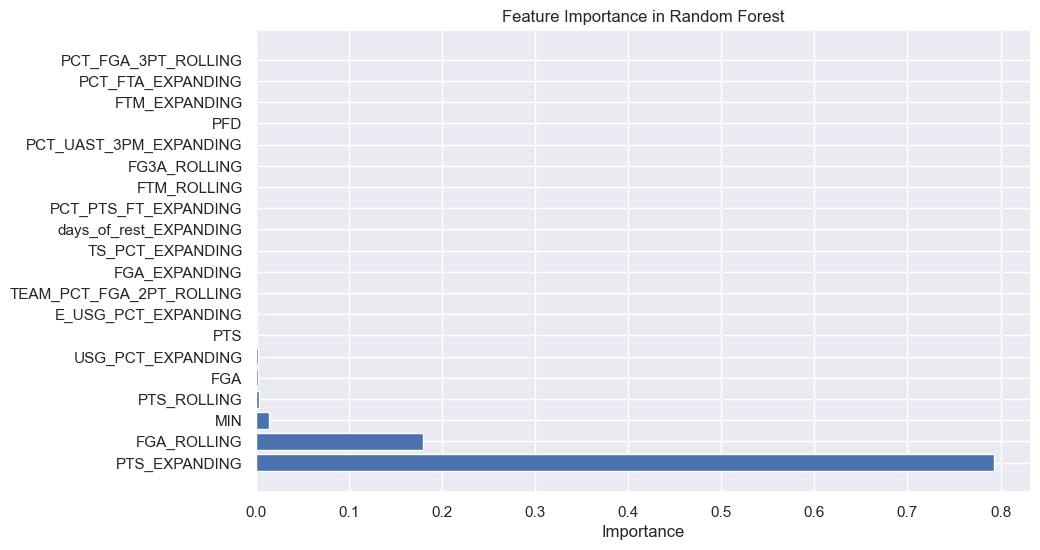

In [99]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Importance')
plt.title('Feature Importance in Random Forest')
plt.show()

Interestingly, a few features are having a major impact on the model's performance. I use a gridsearch to try to optimize the hyperparameters to maximize model performance.  Beforehand, I select only the features that have a feature importance greater than zero to limit the time of the gridsearch.

In [100]:
selected_rf_features_df = importance_df[importance_df['Importance'] != 0]
selected_rf_features = selected_rf_features_df['Feature'].tolist()

In [101]:
random_forest_focused = RandomForestRegressor(max_depth=5,random_state=42)
random_forest.fit(X_train_lasso[selected_rf_features],y_train)

RandomForestRegressor(max_depth=5, random_state=42)

Once again, I record the results of the gridsearch in markdown and/or comments because it takes a long time to run.

In [102]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
}

In [103]:
# rf_grid_search = GridSearchCV(estimator=random_forest_focused, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [104]:
# rf_grid_search.fit(X_train_lasso,y_train)

In [105]:
# best_params = rf_grid_search.best_params_
# best_params

{'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 200}

In [106]:
# best_model = grid_search.best_estimator_
# best_model

Now, I try the random forest model with the optimized grid search hyperparameters.

In [107]:
random_forest_optimized = RandomForestRegressor(max_depth = 7, 
                                                max_features = 'sqrt', 
                                                min_samples_leaf = 4, 
                                                min_samples_split = 2, 
                                                n_estimators = 200)

In [108]:
random_forest_optimized.fit(X_train_lasso[selected_rf_features],y_train)

RandomForestRegressor(max_depth=7, max_features='sqrt', min_samples_leaf=4,
                      n_estimators=200)

In [110]:
Model('rf_test',random_forest_optimized, X_test_lasso[selected_rf_features], y_test)

Model name: rf_test

In [111]:
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531


The optimized random forest performed better than original random forest, but the first mlr model and the ridge model still outperform it in all of the major metrics. Next, I try an extra trees model to see if it gets better results.

### 5d. Extra Trees

Once again, I start off with a max depth of 5 to reduce overfitting and speed up performance.

In [113]:
extra_trees = ExtraTreesRegressor(max_depth = 5, max_features='sqrt')
extra_trees.fit(X_train_lasso,y_train)

ExtraTreesRegressor(max_depth=5, max_features='sqrt')

In [114]:
cross_val_score(extra_trees, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.55008747, -4.74874275, -4.78977053])

In [115]:
Model('extra_trees',extra_trees, X_val_lasso, y_val)
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531
9,extra_trees,38.573400,4.834694,0.472536,41.179394,0.473700


Extra trees performs substantially worse than all of the other models so far, so I move on to see how gradient boost will do.

### 5e. Gradient Boost

In [116]:
gradient_boost = GradientBoostingRegressor(max_depth = 5, max_features='sqrt')
gradient_boost.fit(X_train_lasso,y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt')

In [117]:
cross_val_score(gradient_boost, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

array([-4.33898001, -4.52936847, -4.54801509])

In [118]:
Model('gradient_boost',gradient_boost, X_val_lasso, y_val)
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531
9,extra_trees,38.573400,4.834694,0.472536,41.179394,0.473700


Both in terms of cross validation score and model performance on the validation data, the gradient boosting regressor performs almost as well as my top models. It is the best so far in terms of r squared and explained variance. Based on the results, I use feature importance and grid search to optimize the model.

In [119]:
feature_importances = gradient_boost.feature_importances_

In [120]:
importance_df = pd.DataFrame({'Feature': X_val_lasso.columns, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)
importance_df['Importance'].value_counts()

Importance
0.000000    2
0.000148    1
0.000147    1
0.000144    1
0.000143    1
           ..
0.000364    1
0.000363    1
0.000361    1
0.000348    1
0.000191    1
Name: count, Length: 199, dtype: int64

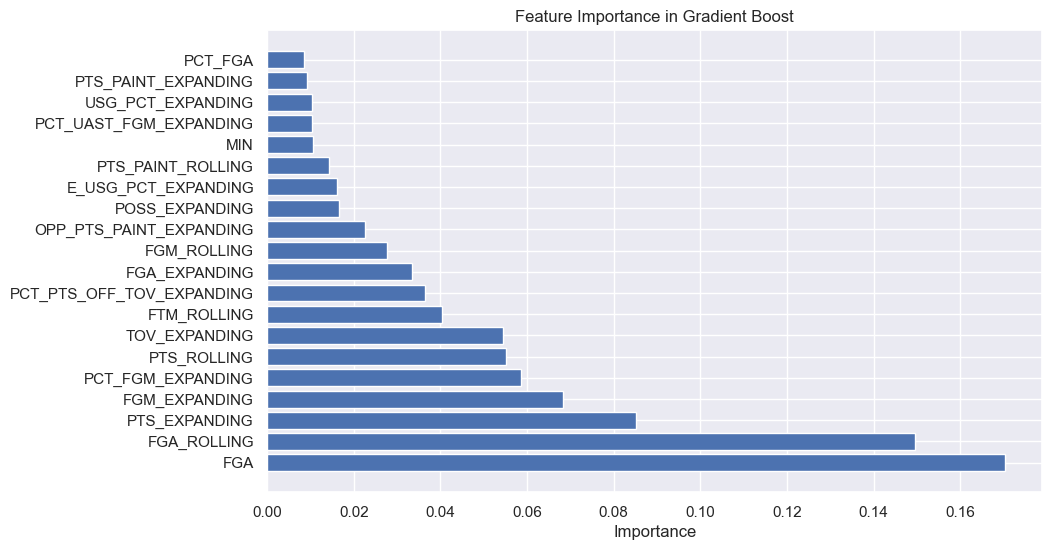

In [121]:
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(20), importance_df['Importance'].head(20))
plt.xlabel('Importance')
plt.title('Feature Importance in Gradient Boost')
plt.show()

In [122]:
selected_gb_features_df = importance_df[importance_df['Importance'].abs() > .001]
selected_gb_features = selected_gb_features_df['Feature'].tolist()

In [123]:
len(selected_gb_features)

41

In [124]:
gradient_boost_focused = GradientBoostingRegressor(random_state=42)
gradient_boost.fit(X_train_lasso[selected_gb_features],y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt')

In [126]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'max_features': ['auto','log','sqrt']
}

In [127]:
#gb_grid_search = GridSearchCV(estimator=gradient_boost_focused, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [128]:
#gb_grid_search.fit(X_train_lasso[selected_gb_features],y_train)

In [129]:
#best_params = gb_grid_search.best_params_
#best_params

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 150, 'max_features':'sqrt'}

In [130]:
#best_model = gb_grid_search.best_estimator_
#best_model

GradientBoostingRegressor(n_estimators=150, random_state=42)

The grid search shows that many of the best hyperparameters are the default settings. I try these with the selected features to see how the model performs.

In [131]:
gradient_boost_best_estimator = GradientBoostingRegressor(n_estimators = 150, random_state=42)
gradient_boost_best_estimator.fit(X_train_lasso[selected_gb_features],y_train)

GradientBoostingRegressor(n_estimators=150, random_state=42)

I check how the model performs on the test data.

In [132]:
Model('gradient_boost_test', gradient_boost_best_estimator, X_test_lasso[selected_gb_features], y_test)
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531
9,extra_trees,38.573400,4.834694,0.472536,41.179394,0.473700


Even after grid search, the model performs worse. This may be because the model from the features I had used were helping the model perform. I try a second grid search with a version of the model that uses all of the original features.

In [134]:
gradient_boost_final = GradientBoostingRegressor(random_state=42)
gradient_boost_final.fit(X_train_lasso,y_train)

GradientBoostingRegressor(random_state=42)

In [135]:
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'max_features': ['auto','log','sqrt']
}

In [136]:
#gb_grid_final = GridSearchCV(estimator=gradient_boost_final, param_grid=param_grid, cv=5, scoring='neg_mean_absolute_error')

In [137]:
#gb_grid_final.fit(X_train_lasso,y_train)

In [138]:
#best_params = gb_grid_final.best_params_
#best_params

{'learning_rate': 0.1,
 'max_depth': 5,
 'max_features': 'sqrt',
 'n_estimators': 150}

In [139]:
#best_model = gb_grid_final.best_estimator_
#best_model

GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=150,
                          random_state=42)

Now that I have the best hyperparameters from gridsearch, I try the optimized model with the test data.

In [140]:
gradient_boost_final_best_estimator = GradientBoostingRegressor(max_depth=5, 
                                                                max_features='sqrt', 
                                                                n_estimators=150,
                                                                random_state=42)

In [141]:
gradient_boost_final_best_estimator.fit(X_train_lasso,y_train)

GradientBoostingRegressor(max_depth=5, max_features='sqrt', n_estimators=150,
                          random_state=42)

In [142]:
Model('gradient_boost_final_test', gradient_boost_final_best_estimator, X_test_lasso, y_test)
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531
9,extra_trees,38.573400,4.834694,0.472536,41.179394,0.473700


Next, I try ada boost to see how it performs.

### 5f. ADA Boost

In [143]:
ada_boost = AdaBoostRegressor(random_state = 42)
ada_boost.fit(X_train_lasso,y_train)

AdaBoostRegressor(random_state=42)

In [144]:
#cross_val_score(ada_boost, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

In [145]:
Model('ada_boost',ada_boost, X_val_lasso, y_val)
Model.model_df

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531
9,extra_trees,38.573400,4.834694,0.472536,41.179394,0.473700


ADA Boost does not perform as well as the other models, so I move on to XG Boost to try one final ensemble method.

### 5g. XG Boost

I leave the objective to the default because reducing mean squared error is appropriate for my project.

In [146]:
xg_boost = xgb.XGBRegressor(max_depth=5,random_state=42)
xg_boost.fit(X_train_lasso,y_train)

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) i

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [147]:
cross_val_score(xg_boost, X_train_lasso, y_train, cv=tscv, scoring='neg_mean_absolute_error')

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) i

array([-4.44620254, -4.5978005 , -4.59041527])

In [148]:
Model('xg_boost', xg_boost, X_val_lasso, y_val)
Model.model_df

C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:299: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:301: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  elif is_categorical_dtype(dtype) and enable_categorical:
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:332: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype)
C:\Users\Hendricks\anaconda3\envs\capstone-env\lib\site-packages\xgboost\data.py:323: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) i

,Name,MSE,MAE,R2,Max Error,Explained Variance
0,baseline_dummy,75.471013,6.675796,-0.032012,51.000000,0.000000
1,mlr_fsm,35.502391,4.563745,0.514530,38.105898,0.515695
2,mlr_pca,37.614455,4.707491,0.485649,40.859462,0.486814
3,mlr_reduced_mc,38.384221,4.764943,0.475123,41.205376,0.476288
4,mlr_test,37.440616,4.630809,0.543188,47.258364,0.549591
5,ridge,35.502376,4.563744,0.514530,38.105909,0.515695
6,ridge_test,37.440436,4.630792,0.543190,47.258836,0.549593
7,rf,36.422184,4.632872,0.501953,37.550533,0.503215
8,rf_test,37.998640,4.679719,0.536379,46.215723,0.542531
9,extra_trees,38.573400,4.834694,0.472536,41.179394,0.473700


Having tried several ensemble models, I try an LSTM neural network to see if it works better with the temporal aspects of the data.

### 5f. LSTM

The project deadline constrains my ability to tune the model, but I try a simple lstm neural network to see how it performs.

In [149]:
lstm_pca = PCA(n_components=10,random_state=42)

In [150]:
X_train_lstm = lstm_pca.fit_transform(X_train_lasso)
X_val_lstm = lstm_pca.fit_transform(X_val_lasso)
X_test_lstm = lstm_pca.fit_transform(X_test_lasso)

In [151]:
X_train_lstm.shape

(146449, 10)

In [152]:
n_steps = 10
n_components = 10

In [153]:
X_sequences = []
y_targets = []

In [154]:
for i in range(len(X_train_lstm) - n_steps):
    seq = X_train_lstm[i:i + n_steps]
    target = y_train[i + n_steps]  
    X_sequences.append(seq)
    y_targets.append(target)

In [155]:
X_sequences = np.array(X_sequences)
y_targets = np.array(y_targets)

In [156]:
X_reshaped = X_sequences.reshape(-1, n_steps, n_components)

In [157]:
lstm_model = Sequential()
lstm_model.add(LSTM(units=50, return_sequences=True, input_shape=(10, 10)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(units=1))
lstm_model.compile(optimizer='adam', loss='mean_absolute_error')

In [158]:
lstm_model.fit(X_reshaped, y_targets, epochs=5, batch_size=300)

Epoch 1/5
489/489 [==============================] - 33s 54ms/step - loss: 6.5863
Epoch 2/5
489/489 [==============================] - 26s 54ms/step - loss: 6.4241
Epoch 3/5
489/489 [==============================] - 26s 53ms/step - loss: 6.4226
Epoch 4/5
489/489 [==============================] - 26s 53ms/step - loss: 6.4222
Epoch 5/5
489/489 [==============================] - 26s 53ms/step - loss: 6.4205


As a next step, I would attempt to further tune the neural network to perform better. However, given the time constraints of the project and the high loss in each epoch, I do not include the lstm in my model class.

## 6. Final Model Selection

The gradient boost with optimized hyperparameters performs best with the test data, so I choose that for my final model. In the next notebook, I dig deeper into the predictions made by the model and interpret the results.